# Log Probs Experiments

## Setup

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import hashlib
import numpy as np
from tqdm import tqdm
import pandas as pd
import json


# Add the project root to the path to allow importing from `part2`
sys.path.insert(0, os.path.abspath('.'))
from part2.logprobs_cli import get_logprobs

sns.set_theme(style="whitegrid")
sns.set_context("notebook", font_scale=1.2)

In [2]:
# Gemini example
get_logprobs(provider='gemini', model_id='gemini-2.5-flash', prompt="Hi?", top_logprobs=3)

{'Hi': 0.8549225832938897,
 'Hello': 0.14476793021149523,
 '"': 0.00010701859002946925}

In [ ]:
# Llama3 example
get_logprobs(provider='ollama', model_id='llama3:8b', prompt="Hi?", top_logprobs=3)

{'Hi': 0.9638845266518407,
 'Hello': 0.03352792241890867,
 'Hey': 0.0025386221052487528}

In [5]:

# --- Mocking Configuration ---
# Set to False to use the live API. Requires API keys and environment variables to be set.
USE_MOCK_DATA = False

MOCK_LOGPROBS = {
    "The capital of the Netherlands is": [(' Amsterdam', 0.9999), (' The', 0.0067), (' The Hague', 0.0003), (' Rotterdam', 0.0001), (' Utrecht', 0.00004)],
    "Is Amsterdam the capital of the Netherlands? (Yes/No)": [(' Yes', 0.9048), (' No', 0.0820), (' The', 0.0024), (' It', 0.0009), (' Amsterdam', 0.0003)],
    "The capital of the Netherlands is: A) The Hague, B) Amsterdam, C) Rotterdam": [(' B', 0.8187), (' B)', 0.3011), (' A', 0.0183), (' C', 0.0067), (' Amsterdam', 0.0024)],
    "Netherlands capital?": [(' Amsterdam', 0.6065), (' The', 0.0497), (' The Hague', 0.0067), (' What', 0.0024), (' ', 0.0009)]
}

def get_data(provider, prompt, model_id, temperature=0, **kwargs):
    """Fetches logprobs from the live API or returns mock data based on the USE_MOCK_DATA flag."""
    if USE_MOCK_DATA:
        # The mock data doesn't change with temperature, 
        # so we return a slightly altered version for visualization purposes.
        print("⚠️ Returning mock data!")
        base_probs = MOCK_LOGPROBS.get(prompt, MOCK_LOGPROBS["The capital of the Netherlands is"])
        if temperature > 0:
            # Simulate temperature effect by flattening the distribution
            tokens, probs = zip(*base_probs)
            scaled_probs = [p**(1/temperature) for p in probs]
            total = sum(scaled_probs)
            final_probs = [p/total for p in scaled_probs]
            return list(zip(tokens, final_probs))
        return base_probs
    else:
        return get_logprobs(
            provider=provider,
            prompt=prompt,
            model_id=model_id,
            temperature=temperature,
            **kwargs
        )

In [6]:
questions = [
    "The capital of the Netherlands is",
    "The number of r's in the word strawberry are ",
    "The largest planet in our solar system is",
    "The chemical symbol for gold is",
    "The number of continents on Earth are",
    "The first president of the United States was",
    "Water boils at this many degrees celsius: ",
    "The speed of light is approximately",
    "The smallest prime number is",
    "The author of Romeo and Juliet is",
    "The capital of Japan is",
    "The number of days in a leap year are",
    "The longest river in the world is",
    "The human body has",
    "The currency of the United Kingdom is",
    "The square root of 144 is",
    "The tallest mountain on Earth is",
    "The freezing point of water is",
    "The number of sides on a hexagon are",
    "The largest ocean on Earth is",
    "The chemical formula for water is",
    "The capital of France is",
    "The number of planets in our solar system are",
    "The inventor of the telephone was",
    "Pi rounded to two decimal places is",
    "The number of bones in the adult human body are approximately",
    "The capital of Australia is",
    "The number of hours in a day are",
    "The smallest country in the world is",
    "The year World War II ended was",
    "The number of strings on a standard guitar are",
    "The capital of Canada is",
    "The hardest natural substance on Earth is",
    "The number of weeks in a year are",
    "The closest star to Earth is",
    "The symbol for iron on the periodic table is",
    "The number of teeth in an adult human are typically",
    "The capital of Italy is",
    "The boiling point of water in Fahrenheit is",
    "The largest mammal on Earth is",
    "The number of seconds in a minute are",
    "The capital of Spain is",
    "The first man on the moon was",
    "The number of zeros in one million are",
    "The smallest bone in the human body is",
    "The capital of Germany is",
    "The number of players on a soccer team are",
    "The gas that plants absorb from the atmosphere is",
    "The distance from Earth to the Sun is approximately",
    "The capital of Egypt is",
    "The number of letters in the English alphabet are",
    "The fastest land animal is",
    "The year the Titanic sank was",
    "The capital of Brazil is",
    "The number of degrees in a right angle are",
    "The largest desert in the world is",
    "The chemical symbol for silver is",
    "The capital of China is",
    "The number of chambers in the human heart are",
    "The smallest planet in our solar system is",
    "The capital of Russia is",
    "The number of cents in a dollar are",
    "The organ that pumps blood through the body is",
    "The capital of India is",
    "The number of minutes in an hour are",
    "The largest land animal is",
    "The year Columbus reached the Americas was",
    "The capital of Mexico is",
    "The number of stripes on the American flag are",
    "The process by which plants make food is called",
    "The capital of South Korea is",
    "The number of legs on a spider are",
    "The coldest planet in our solar system is",
    "The symbol for sodium on the periodic table is",
    "The capital of Argentina is",
    "The number of cents in a quarter are",
    "The largest island in the world is",
    "The capital of Turkey is",
    "The number of sides on a triangle are",
    "The hottest planet in our solar system is",
    "The year the Berlin Wall fell was",
    "The capital of Sweden is",
    "The number of Great Lakes are",
    "The longest bone in the human body is",
    "The capital of Norway is",
    "The number of degrees in a circle are",
    "The metal that is liquid at room temperature is",
    "The capital of Greece is",
    "The number of keys on a standard piano are",
    "The smallest unit of life is",
    "The capital of Portugal is",
    "The number of stars on the American flag are",
    "The force that pulls objects toward Earth is",
    "The capital of Poland is",
    "The number of rings on the Olympic flag are",
    "The year the internet was invented was approximately",
    "The capital of Denmark is",
    "The number of inches in a foot are",
    "The red planet is",
    "The capital of Finland is"
]

In [7]:
# Some metrics to measure logprobs

def _truncate_and_normalize(logprobs, k):
    """Take top-k (token, prob) pairs and renormalize probs."""
    truncated = logprobs[:k]
    probs = np.array([p for _, p in truncated], dtype=float)
    probs /= probs.sum()
    tokens = [t for t, _ in truncated]
    return tokens, probs

def truncated_entropy(logprobs, k=10):
    """Entropy over top-k tokens using log-sum-exp normalization."""
    logps = np.array([lp for _, lp in logprobs[:k]])

    logZ = scipy.special.logsumexp(logps)
    probs = np.exp(logps - logZ)

    return -np.sum(probs * np.log(probs + 1e-12))

def top1_top2_logprob_gap(logprobs):
    """Difference in log-probability between best and second-best token."""
    return logprobs[0][1] - logprobs[1][1]


def semantic_entropy(logprobs, k=10):
    """
    Entropy over semantically-normalized answer strings.
    Groups token variants like 'Am', 'Amsterdam', etc.
    """
    tokens, probs = _truncate_and_normalize(logprobs, k)

    clusters = {}
    for tok, p in zip(tokens, probs):
        key = tok.strip().lower()
        clusters[key] = clusters.get(key, 0.0) + p

    cluster_probs = np.array(list(clusters.values()))
    return -np.sum(cluster_probs * np.log(cluster_probs + 1e-12))


In [13]:
# Investigate determinism, does the same prompt, return the same answer, even with temp set to 0?

# Note that temp doesn't matter for the log probs!
temp = 0

# prompt = "Please answer in 1 number only. The number of r's in the word strawberry are "
prompt_template = "Please answer with your answer only, without any introduction or other explaining text. {question}"

# Accumulate logprob values, cache and 
def get_logprobs_for_questions(questions, model_ids, providers, use_cache=True):
    if isinstance(model_ids, str):
        model_ids = [model_ids]
    if isinstance(providers, str):
        providers = [providers]
    assert len(model_ids) == len(providers), "Providers should be of same length as model_ids"

    cache_hash = hashlib.sha256(
        json.dumps([questions, model_ids, providers], sort_keys=True).encode('utf-8')
    ).hexdigest()
    print("hash:", cache_hash)
    
    cache_file = f'.cached_logprobs_{cache_hash}.pkl'
    if use_cache:
        if os.path.exists(cache_file):
            df = pd.read_pickle(cache_file)
            print(f"Loaded {len(df)} cached results from {cache_file}")
            return df

    df_rows = []

    for provider in providers:
        for model_id in model_ids:
            for q in tqdm(questions, desc=model_id):
                prompt = prompt_template.format(question=q)    
                logprobs = get_data(
                    provider=provider,
                    prompt=prompt,
                    model_id=model_id, 
                    top_logprobs=10,
                    invert_log=False
                )

                # top_logprob = logprobs[0][1]
                # print(f"Prompt: {prompt} -> Top Answer:", logprobs[0][0], logprobs[0][1])

                print(logprobs)
                prob_vals = np.array(list(x for x in logprobs.values()))
                print("PROB_VALS:", prob_vals)
                # logprob_mean = np.mean(prob_vals)
                # print(logprob_mean)

                logprob_var = np.var(prob_vals)

                df_rows.append({
                    'provider': provider,
                    'model_id': model_id,
                    'question': q,
                    'prompt': prompt,
                    'logprob_var': logprob_var,
                    'truncated_entropy': truncated_entropy(logprobs, k=10),
                    'semantic_entropy': semantic_entropy(logprobs, k=10),
                    'top1_top2_gap': top1_top2_logprob_gap(logprobs),
                    'logprob_vals': prob_vals
                })

    df = pd.DataFrame(df_rows)
    df.to_pickle(cache_file)
    print(f"Saved file to {cache_file}")

    return df


model_id = "llama3:8b"
df = get_logprobs_for_questions(questions[:3], model_ids="llama3:8b", providers="ollama", use_cache=False
)
df
# sns.histplot(df['logprob_var'], bins=25)
# plt.title(f"Model={model_id}")
# plt.show()

hash: 96d24c2ff4f9998f3491d05f9401120d0341d34f4d6bc9dfba09d98b1211f557


llama3:8b:   0%|          | 0/3 [00:00<?, ?it/s]

{'Am': -0.00014893600018694997, ' Amsterdam': -9.344341278076172, 'AM': -10.023904800415039, 'A': -12.10175895690918, 'The': -12.619850158691406, '-Am': -12.773319244384766, 'Den': -13.087820053100586, ' amsterdam': -14.399993896484375, 'AMS': -14.746807098388672, 'sterdam': -14.922454833984375}
PROB_VALS: [-1.48936000e-04 -9.34434128e+00 -1.00239048e+01 -1.21017590e+01
 -1.26198502e+01 -1.27733192e+01 -1.30878201e+01 -1.43999939e+01
 -1.47468071e+01 -1.49224548e+01]


KeyError: slice(None, 10, None)

## Temperature Experiment

In [ ]:
default_top_k = 5
default_top_p = 1.0 # include all, let K decide
default_top_logprobs = 5

def get_log_probs_histogram(provider, model, prompt, top_k=default_top_k, top_p=default_top_p, top_logprobs=default_top_logprobs):
    pass



In [ ]:
# 

/var/folders/b3/92n6z87s0t93y9pmdlz3_66dcd4_mv/T/ipykernel_1220/1981360107.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tokens, y=probs, ax=axes[i], palette="viridis")
/var/folders/b3/92n6z87s0t93y9pmdlz3_66dcd4_mv/T/ipykernel_1220/1981360107.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tokens, y=probs, ax=axes[i], palette="viridis")
/var/folders/b3/92n6z87s0t93y9pmdlz3_66dcd4_mv/T/ipykernel_1220/1981360107.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tokens, y=probs, ax=axes[i], palette="viridis")
/var/folders/

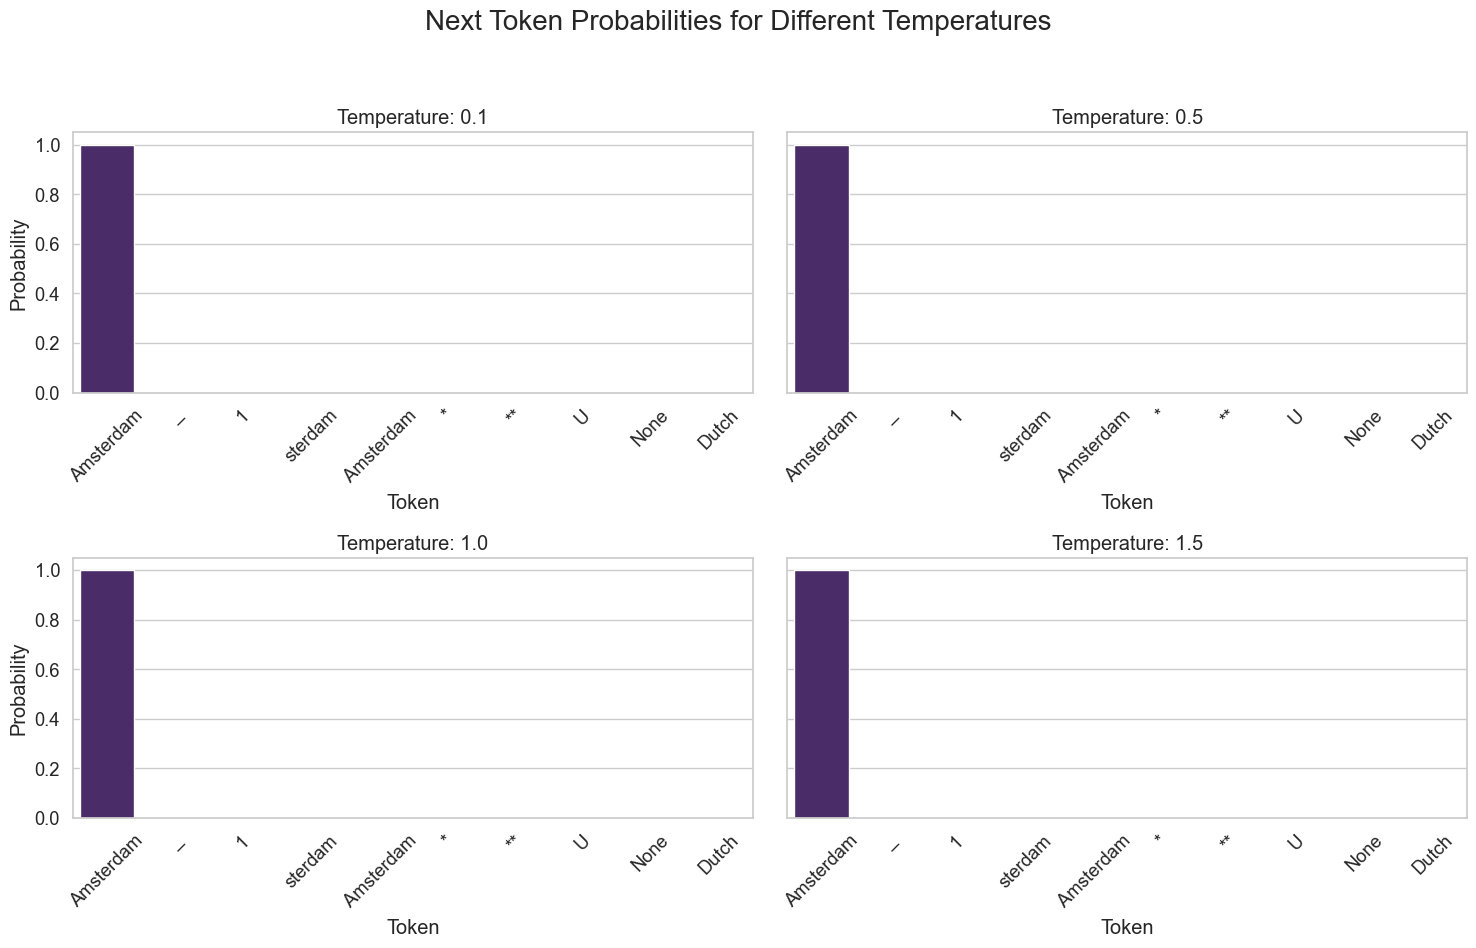

In [13]:
temperatures = [0.1, 0.5, 1.0, 1.5] # Using 0.1 instead of 0.0 for mock calculation stability
prompt_temp = "Please answer the following with only 1 word. The cultural capital of the Netherlands is"

fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharey=True)
axes = axes.flatten()

for i, temp in enumerate(temperatures):
    logprobs = get_data(
        provider="gemini",
        prompt=prompt_temp,
        model_id="gemini-2.5-flash", 
        temperature=temp
    )
    
    tokens = [item[0] for item in logprobs]
    probs = [item[1] for item in logprobs]
    
    sns.barplot(x=tokens, y=probs, ax=axes[i], palette="viridis")
    axes[i].set_title(f"Temperature: {temp}")
    axes[i].set_ylabel("Probability")
    axes[i].set_xlabel("Token")
    axes[i].tick_params(axis='x', rotation=45)

plt.suptitle("Next Token Probabilities for Different Temperatures", fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Prompt Experiment

In [ ]:
prompts = {
    "Freeform": "The capital of the Netherlands is",
    "Binary": "Is Amsterdam the capital of the Netherlands? (Yes/No)",
    "Multiple Choice": "The capital of the Netherlands is: A) The Hague, B) Amsterdam, C) Rotterdam",
    "Poor Prompt": "Netherlands capital?"
}

fig, axes = plt.subplots(2, 2, figsize=(15, 12), sharey=True)
axes = axes.flatten()
fixed_temp = 1.0

for i, (title, prompt) in enumerate(prompts.items()):
    logprobs = get_data(
        provider="gemini",
        prompt=prompt,
        model_id="gemini-1.5-flash",
        temperature=fixed_temp
    )
    
    tokens = [item[0] for item in logprobs]
    probs = [item[1] for item in logprobs]
    
    sns.barplot(x=tokens, y=probs, ax=axes[i], palette="plasma")
    axes[i].set_title(f"Prompt: {title}")
    axes[i].set_ylabel("Probability")
    axes[i].set_xlabel("Token")
    axes[i].tick_params(axis='x', rotation=45)

plt.suptitle(f"Next Token Probabilities for Different Prompts (Temp={fixed_temp})", fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()